# Frame the problem and look at the big picture

* Claramente podemos ver que es un problema de regresión lineal univariada o multivariada.
* La variable a predecir serían dos: casos positivos y muertes.
* Como conjunto para $X$ estaría compuesto principalmente por las fechas.
* Otro punto a tener en cuenta en los datos, es que son datos de forma creciente, casos confirmados, muertes y las fechas son valores cada vez mayores.


# Obtener los datos

### librerias y carga de archivos

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pylab import *

def leer_datos_numpy(text):
    file_1 = pd.read_csv(text, sep=',',header = 0)
    matrix = np.array(file_1)
    return matrix

def leer_datos_panda(text):
    file_1 = pd.read_csv(text, sep=',',header = 0)
    return file_1


In [3]:
covid_cases = leer_datos_panda('covid-19-peru-data.csv')
covid_cases.head()

,country,iso3c,region,date,confirmed,deaths,recovered,negative_cases,pcr_positivo,prueba_rapida_positivo,pcr_prapida_positivo
0,Peru,PER,NaN,2020-03-06,1,NaN,NaN,154.0,NaN,NaN,NaN
1,Peru,PER,NaN,2020-03-07,6,NaN,NaN,213.0,NaN,NaN,NaN
2,Peru,PER,NaN,2020-03-09,9,NaN,NaN,309.0,NaN,NaN,NaN
3,Peru,PER,NaN,2020-03-10,11,NaN,NaN,335.0,NaN,NaN,NaN
4,Peru,PER,NaN,2020-03-11,17,NaN,NaN,697.0,NaN,NaN,NaN


# Explorar los datos

In [4]:
covid_cases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country                 1449 non-null   object 
 1   iso3c                   1449 non-null   object 
 2   region                  1378 non-null   object 
 3   date                    1449 non-null   object 
 4   confirmed               1449 non-null   int64  
 5   deaths                  870 non-null    float64
 6   recovered               89 non-null     float64
 7   negative_cases          71 non-null     float64
 8   pcr_positivo            959 non-null    float64
 9   prueba_rapida_positivo  896 non-null    float64
 10  pcr_prapida_positivo    24 non-null     float64
dtypes: float64(6), int64(1), object(4)
memory usage: 124.6+ KB


In [5]:
covid_cases["region"].value_counts()

Huánuco          65
Cusco            65
Lima             65
Arequipa         65
Ica              65
Piura            63
Ancash           63
Lambayeque       63
Callao           63
La Libertad      63
Loreto           61
Madre de Dios    60
Junín            58
San Martín       55
Tumbes           54
Cajamarca        53
Pasco            51
Tacna            49
Ayacucho         49
Huancavelica     46
Apurimac         44
Moquegua         42
Puno             40
Amazonas         39
Ucayali          37
Name: region, dtype: int64

In [6]:
covid_cases.describe()

,confirmed,deaths,recovered,negative_cases,pcr_positivo,prueba_rapida_positivo,pcr_prapida_positivo
count,1449.000000,870.000000,89.000000,71.000000,959.000000,896.000000,24.000000
mean,1966.208420,88.916092,5092.348315,141043.380282,1082.083420,1845.859375,34.583333
std,8419.205345,272.864975,7717.581725,167464.166958,3581.934751,6845.547152,72.926358
min,1.000000,1.000000,1.000000,154.000000,1.000000,1.000000,1.000000
25%,15.000000,2.000000,5.000000,7078.500000,15.000000,49.750000,1.750000
50%,109.000000,6.000000,537.000000,58864.000000,74.000000,153.500000,3.000000
75%,453.000000,47.000000,7496.000000,249376.500000,257.000000,510.250000,6.250000
max,88541.000000,2523.000000,28272.000000,541941.000000,26234.000000,62307.000000,231.000000


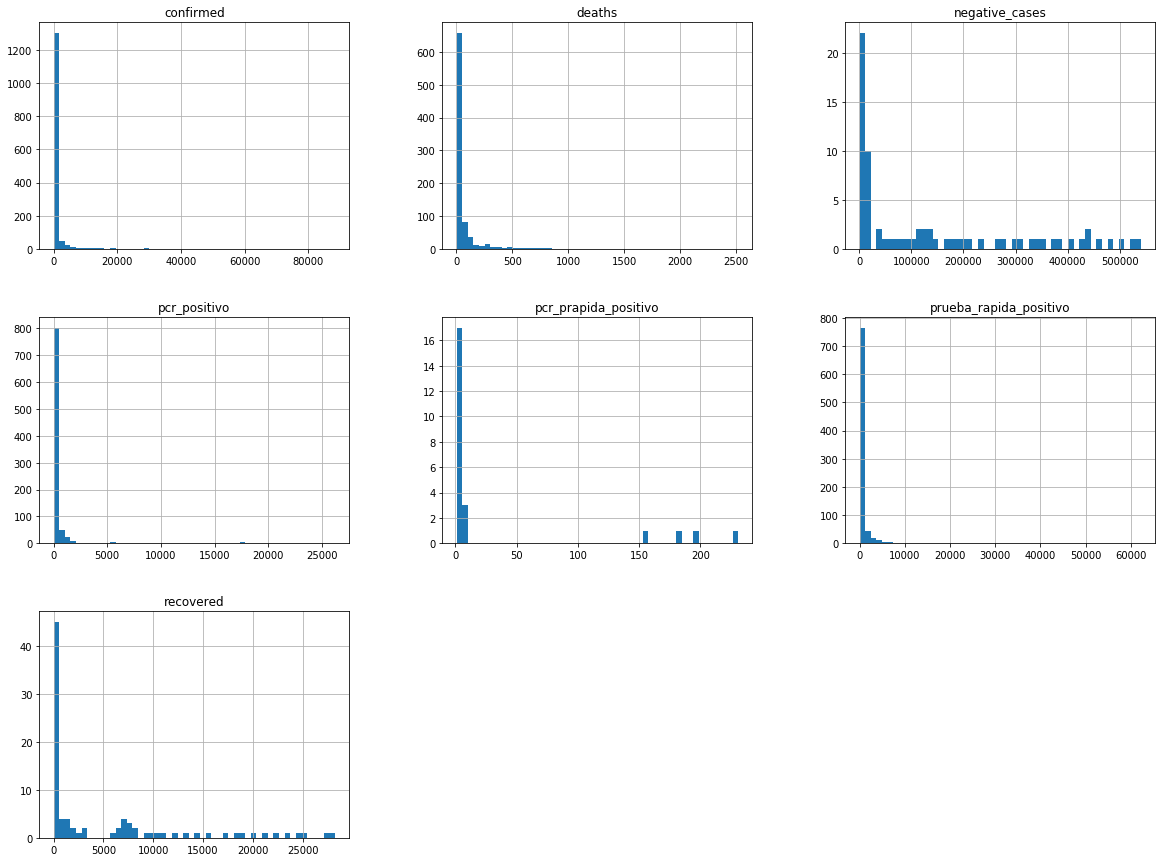

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
covid_cases.hist(bins=50, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

* Vamos a trabajar basicamente con tres columnas: fechas, casos confirmados y muertes.
* Podemos intuir una relación entre los casos confirmados y muertes, para sacar los conjuntos de entrenamiento y prueba. 

# Preparar los datos

### Normalización

In [8]:
def normalizar_datos(matrix):
    promedio = np.sum(matrix, axis = 0)/matrix.shape[0]
    minimos = matrix.min(axis = 0)
    maximos = matrix.max(axis = 0)
    matrix = (matrix - promedio)/(maximos - minimos)
    return matrix

def desnormalizar_datos(matrix, maximo, minimo, promedio):
    return matrix *(maximo-minimo) +promedio


### Conjuntos entrenamiento prueba

In [9]:
def crear_entrenamiento_prueba(matrix):
    sep = int(matrix.shape[0]*0.8)
    entrenamiento = matrix[:sep]
    prueba = matrix[sep:]
    return entrenamiento, prueba

### Creación de subconjuntos

In [10]:
def crear_subconjuntos(entrenamiento):
    sep = entrenamiento.shape[1]-1
    x_array = entrenamiento[:, 0:sep]
    y_array = entrenamiento[:, sep:]
    x_array  = np.concatenate((np.ones((len(x_array), 1)), x_array), axis=1)
    return x_array, y_array


### Llenado de nan

In [11]:
def llenado(matrix, col):
    r_matrix = matrix
    for i in range(r_matrix.shape[0]):
        if(pd.isnull(r_matrix[i][col])):
            r_matrix[i][col] = 0
    return r_matrix

### Fecha a Entero

In [12]:
def fecha_entero(matrix, col):
    r_matrix = matrix
    for i in range(r_matrix.shape[0]):
        dt = np.datetime64(r_matrix[i][col])
        dt64 = np.datetime64(dt)
        ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
        r_matrix[i][col] = ts
    return r_matrix

### Funciones

In [13]:
def filtrado(matrix, text):
    matrix_r = matrix
    if(text == ''):
        ind = pd.isnull(matrix_r[:,0:1])
    else:
        ind = matrix_r[:,0:1] == text
    return matrix_r[ind[:,0],:]


### transformation

In [14]:
# lectura
matrix = leer_datos_numpy('covid-19-peru-data.csv')
#filas hasta el 1 de mayo
matrix_1 = matrix[0:1059,:]
# columnas que me interesan
matrix_muerte = np.array(matrix_1[:,2:6])
matrix_confirmado = np.array(matrix_1[:,2:5])

# reemplazo los nan por 0
matrix_muerte = llenado(matrix_muerte,3)

#print(matrix[:,3:4])
# for i in range(matrix.shape[0]):
#     if(matrix[i:i+1,3:4] == '2020-05-02'):
#         print(i)

        
#convierto fecha a entero
matrix_muerte = fecha_entero(matrix_muerte,1)

matrix_confirmado = fecha_entero(matrix_confirmado,1)

# filtro  a peru y a la region arequipa
peru_muerte = filtrado(matrix_muerte,'')
peru_confirmado = filtrado(matrix_confirmado,'')

arequipa_muerte = filtrado(matrix_muerte,'Arequipa')
arequipa_confirmado = filtrado(matrix_confirmado,'Arequipa')

#elimino la columna region
peru_muerte = peru_muerte[:,1:]
peru_confirmado = peru_confirmado[:,1:]
arequipa_muerte = arequipa_muerte[:,1:]
arequipa_confirmado =  arequipa_confirmado[:,1:]

# print(peru_muerte)
# print(peru_confirmado)
# print(arequipa_muerte)
# print(arequipa_confirmado) 

#guardo los valores para la desnormalizacion
promedio_peru_muerte = np.sum(peru_muerte, axis = 0)/peru_muerte.shape[0]
minimo_peru_muerte = peru_muerte.min(axis = 0)
maximo_peru_muerte = peru_muerte.max(axis = 0) 

promedio_peru_confirmado = np.sum(peru_confirmado, axis = 0)/peru_confirmado.shape[0]
minimo_peru_confirmado = peru_confirmado.min(axis = 0)
maximo_peru_confirmado = peru_confirmado.max(axis = 0)

promedio_arequipa_muerte = np.sum(arequipa_muerte, axis = 0)/arequipa_muerte.shape[0]
minimo_arequipa_muerte = arequipa_muerte.min(axis = 0)
maximo_arequipa_muerte = arequipa_muerte.max(axis = 0) 

promedio_arequipa_confirmado = np.sum(arequipa_confirmado, axis = 0)/arequipa_confirmado.shape[0]
minimo_arequipa_confirmado = arequipa_confirmado.min(axis = 0)
maximo_arequipa_confirmado = arequipa_confirmado.max(axis = 0) 


for i in range(peru_confirmado.shape[0]):
     peru_confirmado[i][0] = i

peru_muerte_normalizada = normalizar_datos(peru_muerte)
peru_confirmado_normalizada = normalizar_datos(peru_confirmado)
arequipa_muerte_normalizada = normalizar_datos(arequipa_muerte)
arequipa_confirmado_normalizada = normalizar_datos(arequipa_confirmado)



#print(peru)
# peru = desnormalizar_datos(peru,maximos,minimos,promedio)
#print(peru)

C:\Users\nibar\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  


In [15]:
def hipotesis(theta_array, x_array):
    return np.dot(x_array, theta_array)

def nuevo_theta_0(theta_0, alpha, h_array, y_array):
    return theta_0 - ( ( alpha /  h_array.shape[0] ) * np.sum( h_array - y_array ) )

def nuevo_theta_1(theta_1, alpha, h_array, y_array, x_array):
    return theta_1 - ( ( alpha /  h_array.shape[0] ) * np.sum( (h_array - y_array) * x_array ))


def calc_nuevos_thetas(theta_array, alpha, h_array, y_array, x_array):
    theta_array[0,0] = theta_array[0,0] - ( ( alpha /  h_array.shape[0] ) * np.sum( h_array - y_array ) )
    for i in range (1, theta_array.shape[0]):
        theta_array[i,0] = theta_array[i,0] - ( ( alpha /  h_array.shape[0] ) * np.sum( ( h_array - y_array )* x_array[:,i:i+1] ) )
    return theta_array

def calcular_costo(h_array, y_array):
    return (1 / (2*h_array.shape[0])) * np.sum( (h_array - y_array) ** 2 )

def RMSE(x_array, theta_array,y_array_real):
    y_array_prediccion = np.zeros((y_array_real.shape[1],1))
    #for i in range (y_array_real.shape[1]):
    y_array_prediccion = np.dot(x_array,theta_array)
    return np.sqrt(( 1 /  y_array_prediccion.shape[0] ) * np.sum( (y_array_prediccion - y_array_real) ** 2 ))



def calcular_accuracy(x_array, y_array, theta_array):
    y_array = y_array > 0
    sigmoidal_array = sigmoidal(theta_array, x_array) >= 0.5
    #print(sigmoidal_array)
    accuracy_array = (sigmoidal_array == y_array)    
    return ((np.sum(accuracy_array)*100) / accuracy_array.shape[0] )




# Gradiente Descendente

In [16]:
def gradiente_descendiente(x_array, y_array, theta_array, num_iteracion, tasa_aprendizaje):
    
    inicio_costos = np.zeros(num_iteracion)
    for i in range(num_iteracion):
        h_array = hipotesis(theta_array, x_array)
        theta_array = calc_nuevos_thetas(theta_array, tasa_aprendizaje, h_array, y_array,x_array)
        inicio_costos[i] = calcular_costo(h_array, y_array)
    return theta_array, inicio_costos

# Short List Promissing Models

casos peru confirmados


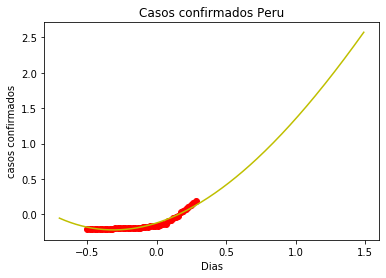

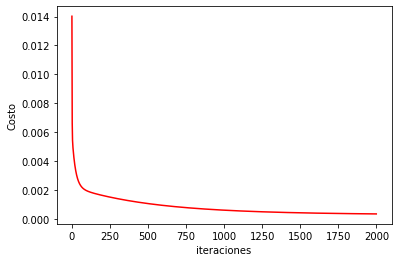

Coeficientes [[-0.12067196]
 [ 0.62437427]
 [ 0.95462196]
 [-0.10822929]]
RMSE 0.20573822009303136
casos Arequipa confirmados


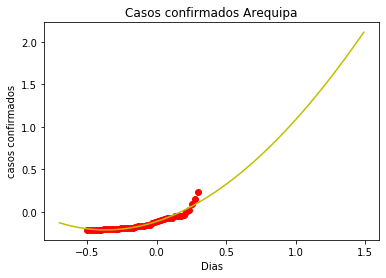

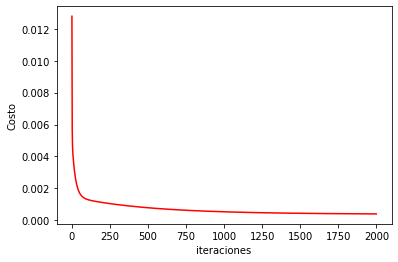

Coeficientes [[-0.11406259]
 [ 0.53390273]
 [ 0.70353807]
 [-0.04008523]]
RMSE 0.2933588291479925
casos Peru muertes


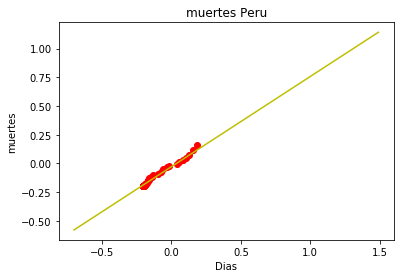

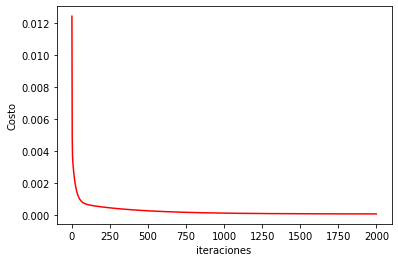

Coeficientes [[-0.02879991]
 [ 0.07168581]
 [ 0.71436574]]
RMSE 0.14448641295771886
casos Arequipa muertes


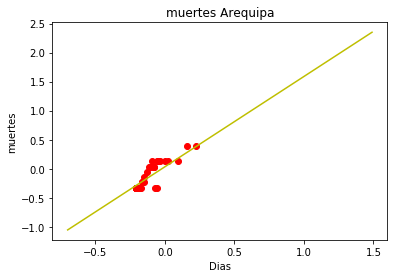

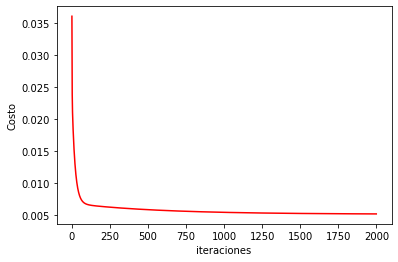

Coeficientes [[0.03481753]
 [0.31508458]
 [1.23847369]]
RMSE 0.24471607879171098


In [20]:

def dibujar(matrix,ite,tasa,c_d,titulo):
    # algoritmos
    entrenamiento, prueba = crear_entrenamiento_prueba(matrix)

    x_array, y_array = crear_subconjuntos(entrenamiento)
    x_array_prueba, y_array_prueba = crear_subconjuntos(prueba)
    

   
    
    if(c_d):
        plt.ylabel("casos confirmados")
        temp_x = np.array(x_array)
        temp_x = np.concatenate((temp_x,x_array[:,1:2]**2),axis=1)
        temp_x = np.concatenate((temp_x,x_array[:,1:2]**3),axis=1)
        
        x_array_prueba = np.concatenate((x_array_prueba,x_array_prueba[:,1:2]**2),axis=1)
        x_array_prueba = np.concatenate((x_array_prueba,x_array_prueba[:,1:2]**3),axis=1)

        theta_array = np.zeros((temp_x.shape[1],1))
        theta_array, costos = gradiente_descendiente(temp_x, y_array, theta_array, ite, tasa) 
        

        
        x_1 = np.arange(-0.7, 1.5,0.01)
        y_1 = theta_array[0,0] + theta_array[1,0] * (x_1) + theta_array[2,0] * (x_1**2) + theta_array[3,0] * (x_1**3) 
        plot(x_array[:,1:2],y_array,'ro')
        plot(x_1,y_1,'y', label='gradiente')
         
    else:
        plt.ylabel("muertes")
        temp_x = np.array(x_array)

        theta_array = np.zeros((temp_x.shape[1],1))
        theta_array, costos = gradiente_descendiente(temp_x, y_array, theta_array, ite, tasa) 
            
        x_1 = np.arange(-0.7, 1.5,0.01)
        

        y_1 = theta_array[0,0] + theta_array[1,0] * (x_1) + theta_array[2,0] * (x_1)
        plot(x_array[:,2:3],y_array,'ro')

        plot(x_1,y_1,'y', label='gradiente')
    
    plt.xlabel("Dias")  

    plt.title(titulo)
    
    
    show()
    
    plt.ylabel("Costo")
    plt.xlabel("iteraciones")  
    plot(costos,'r')
    show()
        
    print("Coeficientes",theta_array)
    print("RMSE",RMSE(x_array_prueba, theta_array, y_array_prueba))
    return theta_array, costos



print("casos peru confirmados")
theta_peru_confirmado, costo_peru_confirmado = dibujar(peru_confirmado_normalizada,2000,0.4,1,"Casos confirmados Peru")
print("casos Arequipa confirmados")
theta_arequipa_confirmado, costo_arequipa_confirmado = dibujar(arequipa_confirmado_normalizada,2000,0.4,1, "Casos confirmados Arequipa")
print("casos Peru muertes")
theta_peru_muerte, costo_peru_muerte = dibujar(peru_muerte_normalizada,2000,0.4,0, "muertes Peru")
print("casos Arequipa muertes")
theta_arequipa_muerte, costo_peru_muerte = dibujar(arequipa_muerte_normalizada,2000,0.4,0, "muertes Arequipa")






### Predicción

In [21]:
def predecir(predict_array,theta_array,c_d,maximo,minimo,promedio):
    # algoritmos

    if(c_d):
        temp_x = np.array(predict_array)
        temp_x = np.concatenate((temp_x,predict_array[:,0:1]**2),axis=1)
        temp_x = np.concatenate((temp_x,predict_array[:,0:1]**3),axis=1)
        
        temp_x  = np.concatenate((np.ones((len(temp_x), 1)), temp_x), axis=1)
        y_1 = hipotesis(theta_array, temp_x)
    else:
        temp_x = np.array(predict_array)
        temp_x = np.concatenate((np.ones((len(temp_x), 1)), temp_x), axis=1)
        temp_x = np.concatenate((temp_x, np.zeros((len(temp_x), 1))), axis=1)
        y_1 = hipotesis(theta_array, temp_x)
    
    y_1 = y_1 *(maximo[1:2]-minimo[1:2]) + promedio[1:2]

    return y_1


dates =  np.arange(np.datetime64('2020-05-16'), np.datetime64('2020-06-14')).reshape(29,1)
x_predict = np.zeros((dates.shape[0],1))
for i in range(dates.shape[0]):
    dt = np.datetime64(dates[i][0])
    dt64 = np.datetime64(dt)
    ts = (dt64 - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    x_predict[i][0] = ts

    
x_predict_1 = (x_predict - promedio_peru_confirmado[0:1])/(maximo_peru_confirmado[0:1] - minimo_peru_confirmado[0:1])
x_predict_2 = (x_predict - promedio_peru_muerte[0:1])/(maximo_peru_muerte[0:1] - minimo_peru_muerte[0:1])
x_predict_3 = (x_predict - promedio_arequipa_confirmado[0:1])/(maximo_arequipa_confirmado[0:1] - minimo_arequipa_confirmado[0:1])
x_predict_4 = (x_predict - promedio_arequipa_muerte[0:1])/(maximo_arequipa_muerte[0:1] - minimo_arequipa_muerte[0:1])


#prediccion
# print("DATOS PREDECIDOS")
# y_predict_1 = predecir(x_predict_1, theta_peru_confirmado,1,maximo_peru_confirmado,minimo_peru_confirmado,promedio_peru_confirmado)
# y_predict_1 = np.concatenate((dates,y_predict_1),axis=1)
# print(y_predict_1)

y_predict_2 = predecir(x_predict_2, theta_peru_muerte,0,maximo_peru_muerte,minimo_peru_muerte,promedio_peru_muerte)
y_predict_2 = np.concatenate((dates,y_predict_2),axis=1)
print(y_predict_2)


# y_predict_3 = predecir(x_predict_3, theta_arequipa_confirmado,1,maximo_arequipa_confirmado,minimo_arequipa_confirmado,promedio_arequipa_confirmado)
# y_predict_3 = np.concatenate((dates,y_predict_3),axis=1)
# print(y_predict_3)

# y_predict_4 = predecir(x_predict_4, theta_arequipa_muerte,0,maximo_arequipa_muerte,minimo_arequipa_muerte,promedio_arequipa_muerte)
# y_predict_4 = np.concatenate((dates,y_predict_4),axis=1)
# print(y_predict_4)

[[datetime.date(2020, 5, 16) 9237.560183217765]
 [datetime.date(2020, 5, 17) 9289.350623880897]
 [datetime.date(2020, 5, 18) 9341.141064544026]
 [datetime.date(2020, 5, 19) 9392.931505207156]
 [datetime.date(2020, 5, 20) 9444.721945870288]
 [datetime.date(2020, 5, 21) 9496.512386533417]
 [datetime.date(2020, 5, 22) 9548.302827196549]
 [datetime.date(2020, 5, 23) 9600.093267859678]
 [datetime.date(2020, 5, 24) 9651.883708522808]
 [datetime.date(2020, 5, 25) 9703.67414918594]
 [datetime.date(2020, 5, 26) 9755.464589849069]
 [datetime.date(2020, 5, 27) 9807.255030512199]
 [datetime.date(2020, 5, 28) 9859.04547117533]
 [datetime.date(2020, 5, 29) 9910.83591183846]
 [datetime.date(2020, 5, 30) 9962.62635250159]
 [datetime.date(2020, 5, 31) 10014.41679316472]
 [datetime.date(2020, 6, 1) 10066.20723382785]
 [datetime.date(2020, 6, 2) 10117.99767449098]
 [datetime.date(2020, 6, 3) 10169.788115154111]
 [datetime.date(2020, 6, 4) 10221.578555817241]
 [datetime.date(2020, 6, 5) 10273.36899648037]

C:\Users\nibar\anaconda3\lib\site-packages\ipykernel_launcher.py:27: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


## Fine-Tune the System

Coefficients: 
 [[0.         0.53695593 1.92458484 2.17856734]]
Independent term: 
 [-0.15061234]
Mean squared error: 0.00
Variance score: 0.99


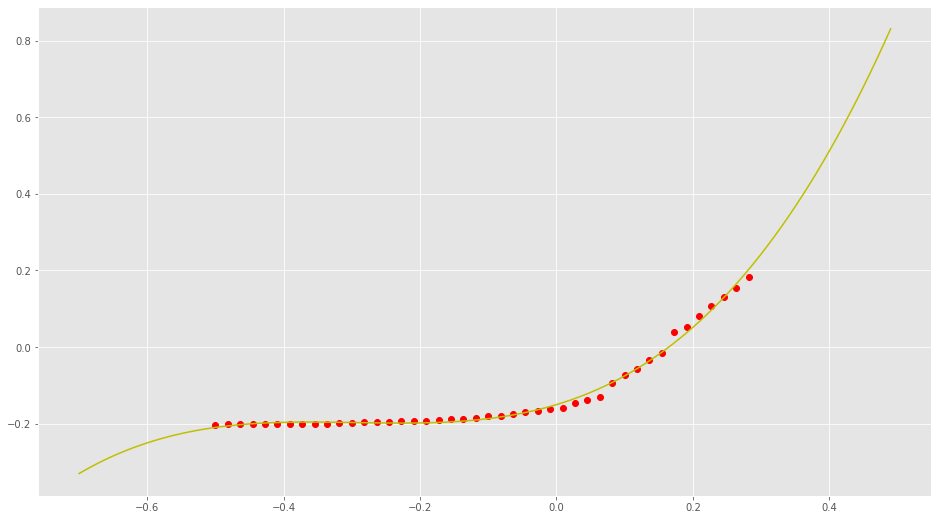

In [459]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.preprocessing import PolynomialFeatures 



# Asignamos nuestra variable de entrada X para entrenamiento y las etiquetas Y.
dataX = covid_cases[["date"]]
X_train = np.array(dataX)
y_train = covid_cases['confirmed'].values



entrenamiento, prueba = crear_entrenamiento_prueba(peru_confirmado_normalizada)

x_array, y_array = crear_subconjuntos(entrenamiento)
x_array_p, y_array_p = crear_subconjuntos(prueba)

x_array = x_array[:,1:]

pf = PolynomialFeatures(degree = 3)    # usaremos polinomios de grado 3
x_array_ = pf.fit_transform(x_array.reshape(-1,1)) 



x_array_p = pf.fit_transform(x_array_p.reshape(-1,1)) 



# Creamos el objeto de Regresión Linear
regr = linear_model.LinearRegression()

# Entrenamos nuestro modelo
regr.fit(x_array_, y_array)
 
# Hacemos las predicciones que en definitiva una línea (en este caso, al ser 2D)
y_pred = regr.predict(x_array_)

c = regr.coef_
# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio
print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# Puntaje de Varianza. El mejor puntaje es un 1.0
print('Variance score: %.2f' % r2_score(y_array, y_pred))

x_2 = np.arange(-0.7, 0.5,0.01)
y_1 = regr.intercept_  + (c[0,1]) * (x_2) + c[0,2] * (x_1**2) + (c[0,3]) * (x_2**3)

plot(x_array,y_array,'ro')
#plot(x_array[:,2:3],y_array,'go')

#plot(x, y,'b',label='normal')
plot(x_1,y_1,'y', label='gradiente')

show()
